---

# Prediciendo _Despacito_ - Notebook

_Universidad Nacional de Colombia - Sede Bogotá_  
Introducción a la Inteligencia Artificial  
2022-II

Juan Pablo Ortega Bermudez - [jortegab@unal.edu.co](mailto:jortegab@unal.edu.co)  
Ana Paulina Castillo Velásquez - [ancastillov@unal.edu.co](mailto:ancastillov@unal.edu.co)   
Sebastian Leonardo Molina Diaz - [smolinad@unal.edu.co](mailto:smolinad@unal.edu.co)   

---

## Configuración del ambiente

A continuación importamos las librerías usadas en el proyecto. El listado de las librerías usadas se encuentra en el [repositorio del proyecto](https://github.com/smolinad/ProyectoFinalIA), en el archivo `requirements.txt`, las cuales pueden ser instaladas con el comando `python -m pip install requirements.txt` en Windows, o con `python3 -m pip install requirements.txt` en Linux o macOS. Recomendamos la creación de un ambiente virtual previo a la instalación de las librerías. Para más información ver https://docs.python.org/3/library/venv.html.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import mca
import random

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, cluster
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential 

from tensorflow.keras.layers import Dense, Input, Activation, Dropout, LeakyReLU
leaky_relu = LeakyReLU(alpha=0.01)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import datetime

En este notebook estamos usando `Python 3.10.8`.

In [3]:
import sys 

sys.version

'3.10.8 (main, Nov 21 2022, 19:53:20) [GCC 11.2.0]'

Para la reproducibilidad de este proyecto, fijaremos la semilla de los generadores pseudo-aleatorios de las librerías que usaremos.

In [4]:
seed_value = 0

os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [5]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

## Importación y procesamiento de datos

A continuación importamos la base de datos de canciones, obtenida de [Kaggle](https://www.kaggle.com/code/harrimansaragih/exploratory-data-analysis-18k-spotify-songs). Esta base de datos consta de aproximadamente 18000 canciones, y un listado de atributos definidos internamente por Spotify.

In [6]:
df = pd.read_csv('spotify_songs.csv')
df

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,0017A6SJgTbfQVU2EtsPNo,Pangarap,Barbie's Cradle,Minsan pa Nang ako'y napalingon Hindi ko alam ...,41,1srJQ0njEQgd8w4XSqI4JQ,Trip,2001-01-01,Pinoy Classic Rock,37i9dQZF1DWYDQ8wBxd7xt,...,-10.068,1,0.0236,0.27900,0.011700,0.0887,0.566,97.091,235440,tl
1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,...,-4.739,1,0.0442,0.01170,0.009940,0.3470,0.404,135.225,373512,en
2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,...,-7.504,0,0.2160,0.00432,0.007230,0.4890,0.650,111.904,262467,en
3,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,2012-10-29,Christmas Soul,6FZYc2BvF7tColxO8PBShV,...,-5.819,0,0.0341,0.68900,0.000000,0.0664,0.405,118.593,243067,en
4,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,37i9dQZF1DX4RDXswvP6Mj,...,-1.993,1,0.0409,0.03700,0.000000,0.1380,0.240,130.018,193160,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18449,7zXzWCVuz7whIuYZyEAlxt,Rising Like The Sun - Radio Mix,Qulinez,"Caught up in such a head rush, wide-eyed latel...",0,1l4aoukbPgi5u2OaE2R4Zj,Rising Like The Sun,2014-03-24,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,...,-5.778,0,0.0878,0.00555,0.000000,0.3350,0.211,128.012,208656,en
18450,7zycSpvjDcqh6YT1FEl2kY,Anaconda,Nicki Minaj,"My anaconda don't, my anaconda don't My anacon...",49,5qs8T6ZHSrnllnOuUk6muC,The Pinkprint (Deluxe Edition),2014-12-15,10er Playlist,1kEczIkZH8IgaWT2BiApxZ,...,-6.224,1,0.1800,0.06730,0.000006,0.2140,0.647,129.990,260240,en
18451,7zye9v6B785eFWEFYs13C2,Bound,Ponderosa Twins Plus One,"Bound, bound Bound, bound Bound to fall in lov...",40,1xdgLmTFMSyJyI5DJOOX7T,2+2+1 = (Digitally Remastered),2013-07-09,Sexy Soul 2020,5EMARioe9z9eKOeWIAC2JW,...,-6.457,0,0.0270,0.71500,0.000428,0.1150,0.657,142.218,191205,en
18452,7zyLObYw4QUKQDyZOb4J0Y,I'll Do 4 U (Re-Recorded / Remastered),Father MC,(Would you do for me) Sweetheart (Would you do...,36,14HYMxFhpgDIr9cci1u0kt,I'll Do 4 U (Re-Recorded / Remastered),2010-10-01,New Jack Swing/ R&B Hits: 1987 - 2002,4sji14lrB5bgcr51lPALYH,...,-4.920,0,0.0633,0.14300,0.000000,0.0720,0.810,109.536,223890,en


Consideramos que se pueden eliminar algunas columnas redundantes en el procesamiento de los datos, como los identificadores únicos de las canciones, subgéneros, letras o _lyrics_, entre otros.

In [7]:
dfnum  = df
dfnum  = dfnum.drop(['playlist_subgenre','track_id','track_name', 'track_artist','lyrics','track_album_id',	'track_album_name','playlist_name',	'playlist_id'], axis=1)
#Now, let's convert date of release to days since realise
dfnum['track_album_release_date'] = pd.to_datetime(dfnum['track_album_release_date'])    
dfnum['days_since_release'] = (dfnum['track_album_release_date'] - dfnum['track_album_release_date'].min())  / np.timedelta64(1,'D')
dfnum  = dfnum.drop('track_album_release_date', axis=1)
dfnum

,track_popularity,playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language,days_since_release
0,41,rock,0.682,0.401,2,-10.068,1,0.0236,0.27900,0.011700,0.0887,0.566,97.091,235440,tl,16071.0
1,28,rock,0.303,0.880,9,-4.739,1,0.0442,0.01170,0.009940,0.3470,0.404,135.225,373512,en,22239.0
2,0,r&b,0.845,0.652,6,-7.504,0,0.2160,0.00432,0.007230,0.4890,0.650,111.904,262467,en,17532.0
3,41,r&b,0.425,0.378,5,-5.819,0,0.0341,0.68900,0.000000,0.0664,0.405,118.593,243067,en,20390.0
4,65,pop,0.760,0.887,9,-1.993,1,0.0409,0.03700,0.000000,0.1380,0.240,130.018,193160,en,22909.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18449,0,edm,0.479,0.800,10,-5.778,0,0.0878,0.00555,0.000000,0.3350,0.211,128.012,208656,en,20901.0
18450,49,pop,0.963,0.603,2,-6.224,1,0.1800,0.06730,0.000006,0.2140,0.647,129.990,260240,en,21167.0
18451,40,r&b,0.458,0.540,5,-6.457,0,0.0270,0.71500,0.000428,0.1150,0.657,142.218,191205,en,20643.0
18452,36,r&b,0.832,0.666,1,-4.920,0,0.0633,0.14300,0.000000,0.0720,0.810,109.536,223890,en,19631.0


<AxesSubplot: xlabel='track_popularity', ylabel='Count'>

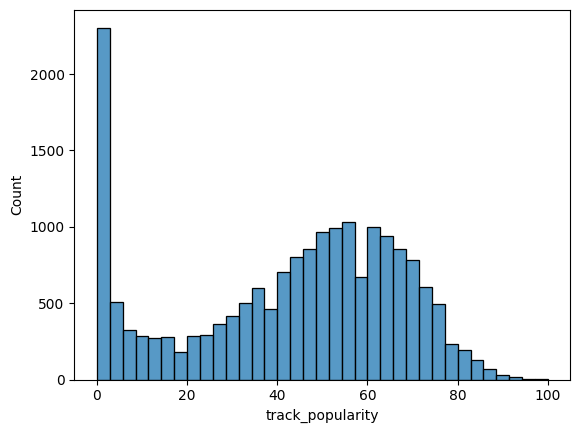

In [8]:
sns.histplot(dfnum.loc[:,'track_popularity'])

In [9]:
dfnum.dtypes

track_popularity        int64
playlist_genre         object
danceability          float64
energy                float64
key                     int64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
duration_ms             int64
language               object
days_since_release    float64
dtype: object

Algunas columnas consisten en parámetros cualitativos que pueden ser importantes para la predicción. Usando la codificación de _one-hot encoding_, asignamos números enteros (0 o 1) a la columna correspondiente. Por ejemplo, el género de una canción puede ser rock, EDM, etc., por lo que con _one-hot encoding_, para la canción '_November Rain_' de Guns n' Roses, la columna `genre_rock` tendrá un valor de 1, en otro caso será 0. Veamos cómo funciona.

In [10]:
y = pd.get_dummies(dfnum.playlist_genre, prefix='genre')
y

,genre_edm,genre_latin,genre_pop,genre_r&b,genre_rap,genre_rock
0,0,0,0,0,0,1
1,0,0,0,0,0,1
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
18449,1,0,0,0,0,0
18450,0,0,1,0,0,0
18451,0,0,0,1,0,0
18452,0,0,0,1,0,0


El análisis de componentes principales —PCA por sus siglas en inglés—, es un método que permite expresar un conjunto de datos en términos de variables que no están correlacionadas, y el cual es usado para reducir el número de parámetros del mismo conjunto de datos. A continuación aplicamos esta técnica.

In [11]:
#numerification of language
z = pd.get_dummies(dfnum.language, prefix='language')
dfqual = pd.concat([y,z], axis=1)
pca = PCA(n_components=6)
dfqual = pca.fit_transform(dfqual)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))
dfqual = pd.DataFrame(data = dfqual, 
                  columns = ['qual0', 'qual1', 'qual2', 'qual3', 'qual4', 'qual5'])

[0.23623753 0.18732462 0.16783144 0.15981959 0.10957926 0.06521964]
0.9260120863101016


Procedemos anormalizar los valores de la base de datos, para que todos los valores estén en el intervalo $[0,1]$.

In [12]:
dfnum  = dfnum.drop(['playlist_genre','language'], axis=1)
dfnum  = pd.concat([dfnum,dfqual],axis=1)
dfnum  = dfnum.astype(float)
dfnum  = NormalizeData(dfnum) #scaling
dfnum

/home/user/.pyenv/versions/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/user/.pyenv/versions/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,days_since_release,qual0,qual1,qual2,qual3,qual4,qual5
0,0.41,0.662692,0.390827,0.181818,0.681000,1.0,0.001340,0.281249,0.011854,0.080414,0.571136,0.338981,0.418893,0.697950,0.387869,0.053253,9.561615e-01,0.300293,0.097080,0.057691
1,0.28,0.232254,0.877962,0.818182,0.830868,1.0,0.024341,0.011793,0.010071,0.342212,0.407663,0.554509,0.703040,0.965821,0.032771,0.000000,9.137683e-01,0.383860,0.143633,0.440446
2,0.00,0.847814,0.646090,0.545455,0.753108,0.0,0.216168,0.004353,0.007325,0.486135,0.655900,0.422702,0.474513,0.761400,0.060372,0.140397,0.000000e+00,0.203910,0.123639,0.443461
3,0.41,0.370812,0.367436,0.454545,0.800495,0.0,0.013064,0.694556,0.000000,0.057812,0.408672,0.460508,0.434589,0.885521,0.060372,0.140397,3.514805e-14,0.203910,0.123639,0.443461
4,0.65,0.751278,0.885081,0.818182,0.908094,1.0,0.020657,0.037297,0.000000,0.130382,0.242172,0.525080,0.331882,0.994919,0.000000,0.892785,5.409271e-01,0.445944,0.179673,0.464863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18449,0.00,0.432141,0.796603,0.909091,0.801648,0.0,0.073024,0.005593,0.000000,0.330049,0.212908,0.513742,0.363772,0.907713,0.146500,0.297476,4.474913e-01,0.452203,1.000000,0.450298
18450,0.49,0.981829,0.596258,0.181818,0.789105,1.0,0.175971,0.067841,0.000006,0.207411,0.652872,0.524922,0.469930,0.919265,0.000000,0.892785,5.409271e-01,0.445944,0.179673,0.464863
18451,0.40,0.408291,0.532188,0.454545,0.782552,0.0,0.005136,0.720766,0.000434,0.107070,0.662963,0.594033,0.327858,0.896508,0.060372,0.140397,2.271674e-14,0.203910,0.123639,0.443461
18452,0.36,0.833049,0.660327,0.090909,0.825778,0.0,0.045668,0.144152,0.000000,0.063488,0.817354,0.409319,0.395123,0.852558,0.060372,0.140397,2.271674e-14,0.203910,0.123639,0.443461


<AxesSubplot: xlabel='track_popularity', ylabel='Count'>

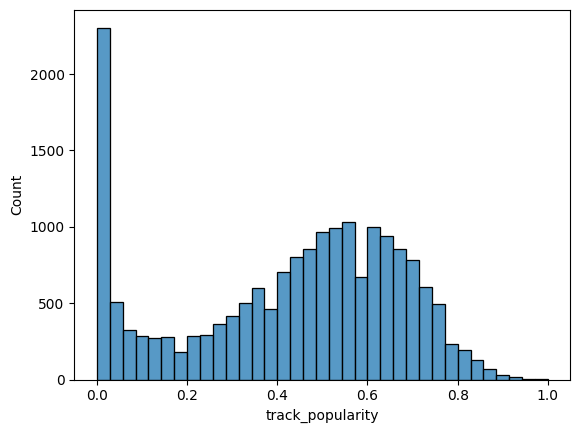

In [13]:
sns.histplot(dfnum.loc[:,'track_popularity'])

In [14]:
dfump = dfnum[dfnum.track_popularity <= 0.05]
dfnum = dfnum[dfnum.track_popularity > 0.05]
dfnum

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,days_since_release,qual0,qual1,qual2,qual3,qual4,qual5
0,0.41,0.662692,0.390827,0.181818,0.681000,1.0,0.001340,0.281249,0.011854,0.080414,0.571136,0.338981,0.418893,0.697950,0.387869,0.053253,9.561615e-01,0.300293,0.097080,0.057691
1,0.28,0.232254,0.877962,0.818182,0.830868,1.0,0.024341,0.011793,0.010071,0.342212,0.407663,0.554509,0.703040,0.965821,0.032771,0.000000,9.137683e-01,0.383860,0.143633,0.440446
3,0.41,0.370812,0.367436,0.454545,0.800495,0.0,0.013064,0.694556,0.000000,0.057812,0.408672,0.460508,0.434589,0.885521,0.060372,0.140397,3.514805e-14,0.203910,0.123639,0.443461
4,0.65,0.751278,0.885081,0.818182,0.908094,1.0,0.020657,0.037297,0.000000,0.130382,0.242172,0.525080,0.331882,0.994919,0.000000,0.892785,5.409271e-01,0.445944,0.179673,0.464863
5,0.70,0.451448,0.632869,0.545455,0.790989,1.0,0.036400,0.282257,0.000000,0.089333,0.307763,0.625378,0.396831,0.988448,0.060372,0.140397,2.279074e-14,0.203910,0.123639,0.443461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18448,0.72,0.733106,0.710160,0.000000,0.792508,1.0,0.366905,0.101813,0.000000,0.083658,0.343081,0.666060,0.304332,0.954095,0.060372,0.140397,2.271674e-14,0.203910,0.123639,0.443461
18450,0.49,0.981829,0.596258,0.181818,0.789105,1.0,0.175971,0.067841,0.000006,0.207411,0.652872,0.524922,0.469930,0.919265,0.000000,0.892785,5.409271e-01,0.445944,0.179673,0.464863
18451,0.40,0.408291,0.532188,0.454545,0.782552,0.0,0.005136,0.720766,0.000434,0.107070,0.662963,0.594033,0.327858,0.896508,0.060372,0.140397,2.271674e-14,0.203910,0.123639,0.443461
18452,0.36,0.833049,0.660327,0.090909,0.825778,0.0,0.045668,0.144152,0.000000,0.063488,0.817354,0.409319,0.395123,0.852558,0.060372,0.140397,2.271674e-14,0.203910,0.123639,0.443461


<AxesSubplot: xlabel='track_popularity', ylabel='Count'>

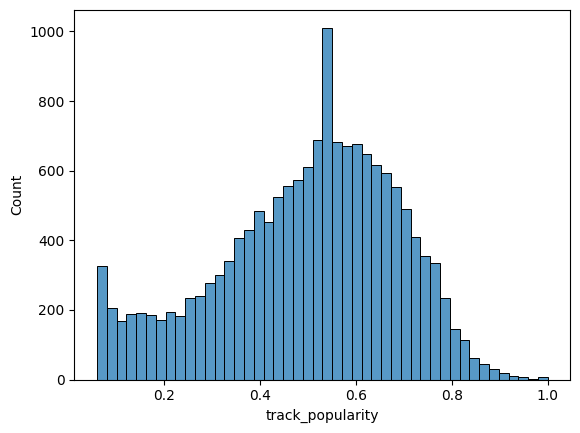

In [15]:
sns.histplot(dfnum.loc[:,'track_popularity'])

## Minería de datos y exploración

En esta sección se buscarán patrones y relaciones ocultos en los datos, con el fin de entender su comportamiento y luego aplicar los modelos. Definimos como `targets` los valores que queremos predecir, es decir, el vector de popularidades de las canciones, y por `features` el resto de parámetros y características.

In [16]:
# Separa features y targest
targets = dfnum.pop('track_popularity')
targets = np.array(targets, dtype = 'float64')
targets.reshape((targets.shape[0],1))

features = np.array(dfnum, dtype = 'float64')

print("Tamaño de los targets: ", targets.shape)
print("Tamaño de los features: ", features.shape)
print(targets)

tamaño de los targets:  (15640,)
tamaño de los features:  (15640, 19)
[0.41 0.28 0.41 ... 0.4  0.36 0.61]


### DBSCAN

Con el método de DBSCAN, intentamos agrupar las canciones en _clusters_ de parámetros similares, lo cual permitiría clasificar las canciones populares fácilmente y así aplicar los modelos en cada uno de los _clusters_ resultantes:

array([-1,  8,  9, ...,  9,  9, -1])

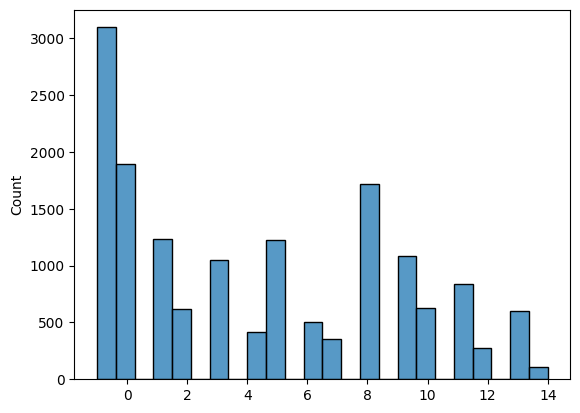

In [17]:
dbscan = cluster.DBSCAN(min_samples=100)
dbscan.fit(features)
sns.histplot(dbscan.labels_)
dbscan.labels_

It seems that clustering didn't work (meaning that there is no clear way to separate it in groups with similar features). Therefore, we are going to model it all together.

Shape of training samples: (12512, 19)
Shape of validation samples: (3128, 19)
[0.23623753 0.18732462 0.16783144 0.15981959 0.10957926 0.06521964]
0.9260120863101016


<AxesSubplot: ylabel='Count'>

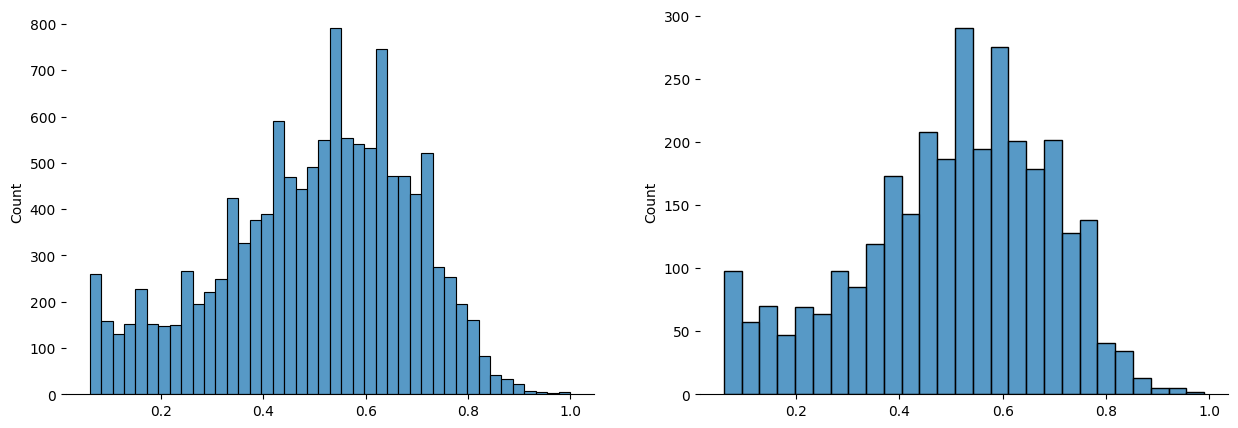

In [18]:
num_val_samples = int(len(features) * 0.2)
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=num_val_samples, shuffle=True)

print("Shape of training samples:", np.shape(train_features))
print("Shape of validation samples:", np.shape(val_features))
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
# fig.suptitle('Initial Pokemon - 1st Generation')
sns.despine(left=True)
sns.histplot(ax=axes[0],x=train_targets)
sns.histplot(ax=axes[1],x=val_targets)

# Building our predicition model

Now that our data is clear and understood, we are ready for the good part! Builing our Maching Leaning models. We are going to try two approaches: Neural Networks and Reggresion Random Forests.

In [19]:
class CustomModel(Model): #the NN approach
    
    def __init__(self, **kwargs):
        super(CustomModel, self).__init__(**kwargs)
        self.dense1   = Dense(32, activation='leaky_relu')
        self.dropout1 = Dropout(.2, input_shape=(32,))
        self.dense2   = Dense(256, activation='leaky_relu') #si 56: 64,32,8,1
        self.dropout2 = Dropout(.2, input_shape=(256,)) 
        self.dense3   = Dense(512, activation='leaky_relu')
        self.dropout3 = Dropout(.2,input_shape=(512,))
        self.dense4   = Dense(256, activation='leaky_relu')
        self.dropout4 = Dropout(.2, input_shape=(256,))
        self.dense5   = Dense(128, activation='leaky_relu')
        self.dropout5 = Dropout(.2, input_shape=(128,))
        self.dense6   = Dense(16, activation='leaky_relu')
        self.dropout6 = Dropout(.2, input_shape=(16,))
        self.dense7   = Dense(8, activation='leaky_relu')
        self.dropout7 = Dropout(.2, input_shape=(8,))
        self.dense8   = Dense(1, activation='sigmoid')
        
    def call(self, inputs):                    
        x = self.dense1(inputs)                
        x = self.dropout1(x)                   
        x = self.dense2(x)
        x = self.dropout2(x)
        x = self.dense3(x)
        x = self.dropout3(x)
        x = self.dense4(x)
        x = self.dropout4(x)
        x = self.dense5(x)
        x = self.dropout5(x)
        x = self.dense6(x)
        x = self.dropout6(x)
        x = self.dense7(x)
        x = self.dropout7(x)
        return self.dense8(x)

In [20]:
model_spotify = CustomModel(name='my_custom_model')
model_spotify.compile(optimizer=Adam(5e-5),
              loss='mse',
              metrics=["mae"])

In [21]:
history = model_spotify.fit(
    train_features,
    train_targets,
    batch_size=200,
    epochs=1000,
    verbose=0,
    validation_data=(val_features, val_targets)
)

KeyboardInterrupt: 

In [ ]:
score = model_spotify.evaluate(val_features, val_targets)
print(score)
model_spotify.metrics_names

In [ ]:
y_prediction = model_spotify.predict(val_features)
y_prediction = np.squeeze(y_prediction)
g = plt.figure()
plt.scatter(val_targets, y_prediction)
plt.xlabel('Targets')
plt.ylabel('Predictions')
plt.show()
g.savefig('plots/correlacionerroresNN.eps', format='eps', dpi=1000)
my_rho = np.corrcoef(val_targets, y_prediction)
print(my_rho)


In [ ]:
g = sns.histplot(y_prediction)
fig = g.get_figure()
fig.savefig("plots/cuentacancionesNN.eps", format='eps', dpi=1000) 

We can see that the results are not quite good. The corelation coefficient is too low and the distribution of the predicted values does not match the targets. Let's try the other approach and see if this situation gets better.

In [ ]:
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 1000, random_state = random.seed(0) ,max_depth=1000, verbose=0)
  
# fit the regressor with x and y data
regressor.fit(train_features, train_targets)

In [ ]:
y_prediction = regressor.predict(val_features)
y_prediction = np.squeeze(y_prediction)
r = plt.figure()
plt.scatter(val_targets, y_prediction)
plt.xlabel('Targets')
plt.ylabel('Predictions')
plt.show()
r.savefig('plots/correlacionerroresRF.eps', format='eps', dpi=1000)
my_rho = np.corrcoef(val_targets, y_prediction)
print(my_rho)
err = (np.linalg.norm(y_prediction-val_targets))**2/len(y_prediction)
print('Error during validation: ',err)

In [ ]:
h = sns.histplot(y_prediction)
fig = h.get_figure()
fig.savefig("plots/cuentacancionesRF.eps", format='eps', dpi=1000) 

We can see that, even though the results are not what we expected, there is an important improvement compared with the first approach (better corelation and distribution). Nevertheless, there is a lot of room for more improvement. Notably, we can work with the fact that both models failed to predict the deviation of the data, targeting excessively the mean values. We could fix this problem by over-sampling the songs that are closer to the extreme values 0 and 100 and see if this helps our models.